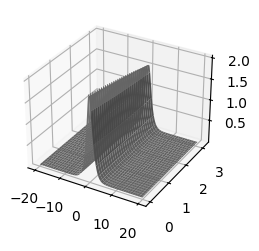

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

U1 = np.load('U1.npy')
U2 = np.load('U2.npy')
L = 40
n = 512
x2 = np.linspace(-L/2, L/2, n+1)
x = x2[:n]
k = (2*np.pi/L) * np.concatenate((np.arange(0, n//2), np.arange(-n//2, 0)))

def nsol_ode_rhs(y0, t, alpha11, alpha12, alpha21, alpha22, beta11_1, beta22_1, beta12_1, beta21_1, beta11_2, beta22_2, beta21_2, beta12_2, sigma12_1, sigma21_1, sigma12_2, sigma21_2):
    nsol_ode_rhs = [
        - (alpha11*y0[0] + alpha12*y0[1] + (beta11_1*abs(y0[0])**2 + 2*beta21_1*abs(y0[1])**2)*y0[0] 
           + (beta12_1*abs(y0[0])**2 + 2*beta22_1*(abs(y0[1])**2))*y0[1] 
           + sigma12_1*y0[0]**2*np.conj(y0[1]) + sigma21_1*y0[1]**2*np.conj(y0[0])) / 1j,
        - (alpha21*y0[0] + alpha22*y0[1] + (beta11_2*abs(y0[0])**2 + 2*beta21_2*abs(y0[1])**2)*y0[0] 
           + (beta12_2*abs(y0[0])**2 + 2*beta22_2*(abs(y0[1])**2))*y0[1] 
           + sigma12_2*y0[0]**2*np.conj(y0[1]) + sigma21_2*y0[1]**2*np.conj(y0[0])) / 1j
    ]
    return nsol_ode_rhs

for jloop in range(1, 3):
    U = np.zeros((len(x), 2), dtype=np.complex128)
    if jloop == 1:
        U[:, 0] = U1[:, 0]
        U[:, 1] = U1[:, 1]
    else:
        U[:, 0] = U2[:, 0]
        U[:, 1] = U2[:, 1]

    phi_1_xx = np.fft.ifft(-(k**2)*np.fft.fft(U[:, 0]))
    phi_2_xx = np.fft.ifft(-(k**2)*np.fft.fft(U[:, 1]))

    norm1 = np.trapz(U[:, 0]*np.conj(U[:, 0]), x)
    norm2 = np.trapz(U[:, 1]*np.conj(U[:, 1]), x)

    A0_1 = np.trapz(2.0*np.cosh(x)**(-1)*np.conj(U[:, 0]), x) / norm1
    A0_2 = np.trapz(2.0*np.cosh(x)**(-1)*np.conj(U[:, 1]), x) / norm2

    alpha11 = np.trapz(np.conj(U[:, 0])*phi_1_xx, x) / norm1
    alpha12 = np.trapz(np.conj(U[:, 0])*phi_2_xx, x) / norm1
    beta11_1 = np.trapz((U[:, 0]*np.conj(U[:, 0]))**2, x) / norm1
    beta22_1 = np.trapz(U[:, 1]*(abs(U[:, 1])**2)*np.conj(U[:, 0]), x) / norm1
    beta21_1 = np.trapz(U[:, 0]*(abs(U[:, 1])**2)*np.conj(U[:, 0]), x) / norm1
    beta12_1 = np.trapz(U[:, 1]*(abs(U[:, 0])**2)*np.conj(U[:, 0]), x) / norm1
    sigma12_1 = np.trapz(np.conj(U[:, 1])*(U[:, 0]**2)*np.conj(U[:, 0]), x) / norm1
    sigma21_1 = np.trapz(np.conj(U[:, 0])*(U[:, 1]**2)*np.conj(U[:, 0]), x) / norm1

    alpha21 = np.trapz(np.conj(U[:, 1])*phi_1_xx, x) / norm2
    alpha22 = np.trapz(np.conj(U[:, 1])*phi_2_xx, x) / norm2
    beta11_2 = np.trapz(U[:, 0]*(abs(U[:, 0])**2)*np.conj(U[:, 1]), x) / norm2
    beta22_2 = np.trapz(U[:, 1]*(abs(U[:, 1])**2)*np.conj(U[:, 1]), x) / norm2
    beta21_2 = np.trapz(U[:, 0]*(abs(U[:, 1])**2)*np.conj(U[:, 1]), x) / norm2
    beta12_2 = np.trapz(U[:, 1]*(abs(U[:, 0])**2)*np.conj(U[:, 1]), x) / norm2
    sigma12_2 = np.trapz(np.conj(U[:, 1])*(U[:, 0]**2)*np.conj(U[:, 1]), x) / norm2
    sigma21_2 = np.trapz(np.conj(U[:, 0])*(U[:, 1]**2)*np.conj(U[:, 1]), x) / norm2

    t = np.linspace(0, np.pi, 31)
    y0 = [A0_1, A0_2]
    u_ode = odeint(nsol_ode_rhs, y0, t, args=(alpha11, alpha12, alpha21, alpha22, beta11_1, beta22_1, beta12_1, beta21_1, beta11_2, beta22_2, beta21_2, beta12_2, sigma12_1, sigma21_1, sigma12_2, sigma21_2))

    urom = np.zeros((len(x), len(t)), dtype=np.complex128)
    for jcons in range(len(t)):
        urom[:, jcons] = u_ode[jcons, 0]*U[:, 0] + u_ode[jcons, 1]*U[:, 1]

    X, T = np.meshgrid(x, t)
    
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(X, T, np.abs(urom.T), color='gray')
plt.show()
